In [1]:
import datetime

import numpy as np
import pandas as pd

import vectorbt as vbt

In [2]:
end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(days=7)

interval = "1m"

In [3]:
symbols = [
    "BTC-USD", 
    "ETH-USD"
]

windows = [
    14,
    21
]

In [4]:
price = vbt.YFData.download(
    symbols = symbols,
    missing_index='drop',
    interval=interval,
    start = start_time,
    end = end_time
).get('Close')

/home/oskar/anaconda3/envs/vectorbt/lib/python3.10/site-packages/vectorbt/data/base.py:527: UserWarning: Symbols have mismatching index. Dropping missing data points.
  data = cls.align_index(data, missing=missing_index)


In [5]:
price

symbol,BTC-USD,ETH-USD
Datetime,,
2023-05-20 00:01:00+00:00,26881.042969,1812.737915
2023-05-20 00:02:00+00:00,26883.082031,1812.724854
2023-05-20 00:03:00+00:00,26885.652344,1812.723022
2023-05-20 00:04:00+00:00,26888.812500,1812.892578
2023-05-20 00:05:00+00:00,26891.382812,1813.088257
...,...,...
2023-05-26 23:53:00+00:00,26717.939453,1828.923828
2023-05-26 23:54:00+00:00,26719.158203,1828.898315
2023-05-26 23:55:00+00:00,26717.449219,1828.721069


In [6]:
# this will work only for  one symbol passed to indicator factory
# this needs to be cnoverrted to some vecotrbt function instead o numpy to support multiple symbols
def custom_indicator(close, rsi_window = 14, ma_window = 50):
    
    # requires keep_pd=False to return numpy array
    assert isinstance(close, np.ndarray)

    # convert to numpy array to calculate custom indicator
    rsi = vbt.RSI.run(close, window = rsi_window).rsi.to_numpy()
    ma = vbt.MA.run(close, window = ma_window).ma.to_numpy()

    # when rsi is above 70 then -1 (sell)
    trend = np.where(rsi > 70, -1, 0)
    # when rsi is below 30 and price is below moving average then 1 (buy)
    trend = np.where((rsi < 30) & (close < ma), 1, trend)

    return trend

In [7]:
# this is a wierd strategy, but it shows what can be done with custom indicators
def custom_indicator(close, rsi_window = 14, ma_window = 50):
    assert isinstance(close, pd.DataFrame) or isinstance(close, pd.Series)

    close_5m = close.resample('5T').last()
    rsi = vbt.RSI.run(close_5m, window = rsi_window).rsi
    
    rsi, _ = rsi.align(
        close,
        broadcast_axis=0,
        method="ffill",
        join='right'
    )

    close = close.to_numpy()
    rsi = rsi.to_numpy()
    ma = vbt.MA.run(close, ma_window).ma.to_numpy()

    # when rsi is above 70 then -1 (sell)
    trend = np.where(rsi > 70, -1, 0)
    # when rsi is below 30 and price is below moving average then 1 (buy)
    trend = np.where((rsi < 30) & (close < ma), 1, trend)

    return trend

In [8]:
indicator = vbt.IndicatorFactory(
    class_name = 'Combination',
    short_name='comb',
    input_names=['close'],
    param_names=['rsi_window', 'ma_window'],
    output_names=['value']
).from_apply_func(
    custom_indicator,
    rsi_window=[21, 25],
    ma_window=50,
    keep_pd=True # close will be passed as pandas series instead of numpy array
)

In [9]:
res = indicator.run(price, rsi_window=21, ma_window=50)

In [10]:
cols = res.value.columns
print(cols)
res.value

MultiIndex([(21, 50, 'BTC-USD'),
            (21, 50, 'ETH-USD')],
           names=['comb_rsi_window', 'comb_ma_window', 'symbol'])


comb_rsi_window                21        
comb_ma_window                 50        
symbol                    BTC-USD ETH-USD
Datetime                                 
2023-05-20 00:01:00+00:00       0       0
2023-05-20 00:02:00+00:00       0       0
2023-05-20 00:03:00+00:00       0       0
2023-05-20 00:04:00+00:00       0       0
2023-05-20 00:05:00+00:00       0       0
...                           ...     ...
2023-05-26 23:53:00+00:00       0       0
2023-05-26 23:54:00+00:00       0       0
2023-05-26 23:55:00+00:00       0       0
2023-05-26 23:56:00+00:00       0       0
2023-05-26 23:57:00+00:00       0       0

[9972 rows x 2 columns]

<Axes: xlabel='Datetime'>

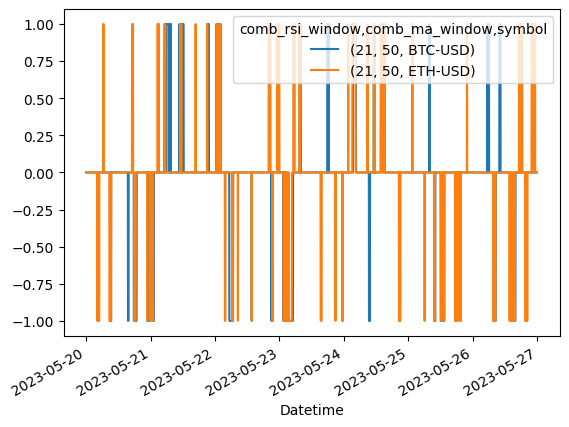

In [11]:
res.value.plot()

In [12]:
entries = res.value == 1
exits = res.value == -1

In [13]:
pf = vbt.Portfolio.from_signals(price, entries, exits, fees=0.001, freq=interval)

In [14]:
pf.plot(column=cols[0], show_titles=True, title='Portfolio Value')

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'be055260-e489-4232-8670-8f12134241c9',
              'x': array([datetime.datetime(2023, 5, 20, 0, 1, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 5, 20, 0, 2, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 5, 20, 0, 3, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 5, 26, 23, 55, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 5, 26, 23, 56, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 5, 26, 23, 57, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'xaxis': 'x',
              'y': array([26881.04296875, 26883.08203125, 26885.65234375, ..., 26717.44921875,
         